In [1]:
import fsspec
import zarr

In [2]:
m = fsspec.get_mapper("http://macadamia.bgc-jena.mpg.de:9052")
g = zarr.open_consolidated(m)

In [8]:
batches = g["batches"]

In [9]:
batches.shape

(100, 3, 736)

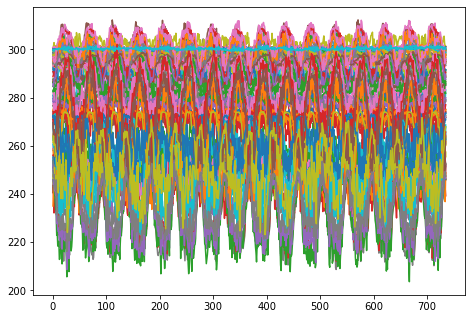

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
for i in range(100):
    ax.plot(batches[i,2,:])